In [1]:
from mplsoccer.pitch import Pitch, VerticalPitch
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from highlight_text import HighlightText, ax_text, fig_text
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
import matplotlib.patheffects as path_effects

In [2]:
data = pd.read_csv("T5_Leagues_2425.csv" , low_memory=False)
data['x'] = data['x']*1.2
data['y'] = data['y']*.8
data['endX'] = data['endX']*1.2
data['endY'] = data['endY']*.8

In [3]:
def add_carries(game_df):
   min_dribble_length: float = 0.0
   max_dribble_length: float = 100.0
   max_dribble_duration: float = 20.0
   game_df['time_seconds']=game_df['minute']*60+game_df['second']
   next_actions = data.shift(-1)
   same_game=game_df.gameId==next_actions.gameId
   same_team = game_df.teamId == next_actions.teamId
   dx = game_df.endX - next_actions.x
   dy = game_df.endY- next_actions.y
   far_enough=dy** 2 + dy** 2 >= min_dribble_length** 2
   not_too_far = dx ** 2+ dy** 2<= max_dribble_length ** 2
   dt = next_actions.time_seconds - game_df.time_seconds
   same_phase = dt < max_dribble_duration
   same_period = game_df.period == next_actions.period
   dribble_idx = same_team & far_enough & not_too_far & same_phase & same_period&same_game
   dribbles = pd.DataFrame()
   prev = game_df[dribble_idx]
   nex= next_actions[dribble_idx]
   dribbles['gameId' ] = nex.gameId
   dribbles['period' ] = nex.period
   for cols in ['expandedMinute']:
      dribbles[cols] = nex[cols]
   for cols in ['passKey','assist']:
      dribbles[ cols] = [True for _ in range (len (dribbles))]
   dribbles['isTouch'] = [True for _ in range (len (dribbles))]
   morecols = ['playerId', 'team','player']
   for cols in morecols:
      dribbles[cols] = nex[cols]
   #dribbles['action_id'] = prev.eventId + 0.1
   dribbles['time_seconds' ] = (prev.time_seconds + nex.time_seconds) / 2
   dribbles['teamId'] = nex.teamId
   dribbles['playerId']= nex.playerId
   dribbles['player' ]= nex.player
   dribbles['x'] = prev.endX
   dribbles['y']= prev.endY
   dribbles['endX'] = nex.x
   dribbles['endY'] = nex.y
   dribbles['type'] = ['Carry' for _ in range(len(dribbles))]
   dribbles['outcomeType'] = ['Successful' for _ in range(len(dribbles))]
   dribbles['qualifiers']=[{} for _ in range(len(dribbles))]
   game_df=pd.concat([game_df,dribbles], ignore_index=True,sort=False)
   game_df=game_df.sort_values(['gameId','period']).reset_index(drop=True)
   game_df['action_id']=range(len(game_df))
   return game_df

In [4]:
data = add_carries(data)

In [6]:
data_carries = data[data['type'] == 'Carry']

In [15]:
data_passes = data[(data['type'] == 'Pass') & (data['outcomeType'] == 'Successful') & (data['x'] <= 119.2)]

In [31]:
x_min = 102
x_max = 120       # width = 18
y_min = 18
y_max = 62 



data_passes['in_pen_box'] = (data_passes['x'].between(x_min, x_max) & 
                          data_passes['y'].between(y_min, y_max))

data_carries['in_pen_box'] = (data_carries['x'].between(x_min, x_max) & 
                          data_carries['y'].between(y_min, y_max))

data_passes['into_pen_box'] = (data_passes['endX'].between(x_min, x_max) & 
                           data_passes['endY'].between(y_min, y_max) & 
                           (data_passes['in_pen_box'] == False))

data_carries['into_pen_box'] = (data_carries['endX'].between(x_min, x_max) & 
                           data_carries['endY'].between(y_min, y_max) & 
                           (data_carries['in_pen_box'] == False))

box_passes = data_passes[data_passes['into_pen_box']]
box_carries = data_carries[data_carries['into_pen_box']]


# Group and aggregate
box_passes_grouped = box_passes.groupby(['playerId', 'player', 'team']).size().reset_index(name='box_passes')
box_carries_grouped = box_carries.groupby(['playerId', 'player', 'team']).size().reset_index(name='box_carries')


result_df_box = pd.merge(box_passes_grouped, box_carries_grouped, on=['playerId', 'player', 'team'], how='outer').fillna(0)
result_df_box['box_actions'] = result_df_box['box_passes'] + result_df_box['box_carries']


info = pd.read_csv("T5_League_Mins_2025.csv")
info['90s'] = info['Mins'] / 90

result_df_box = pd.merge(result_df_box, info, on=['player', 'team'], how='left')
result_df_box['box_actions_p90'] = result_df_box['box_actions'] / result_df_box['90s']
#combined_prog_df['prog_lhs_actions_p90'] = combined_prog_df['prog_lhs_actions'] / combined_prog_df['90s']
result_df_box = result_df_box[(result_df_box['90s'] >= 15) & (result_df_box['position'] != 'GK')
                              & (result_df_box['age'] <= 23)
                                    
                                    
                                ]


result_df_box = result_df_box.drop_duplicates(subset=['player'])
top_12_box = result_df_box.sort_values("box_actions_p90", ascending=False).head(12)

top_12_box




/var/folders/yd/kz4hmn8n5d102wb_dk7p1gf00000gn/T/ipykernel_26749/1793685143.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_passes['in_pen_box'] = (data_passes['x'].between(x_min, x_max) &
/var/folders/yd/kz4hmn8n5d102wb_dk7p1gf00000gn/T/ipykernel_26749/1793685143.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_carries['in_pen_box'] = (data_carries['x'].between(x_min, x_max) &
/var/folders/yd/kz4hmn8n5d102wb_dk7p1gf00000gn/T/ipykernel_26749/1793685143.py:15: SettingWithCopyWarning: 
A val

,playerId,player,team,box_passes,box_carries,box_actions,Unnamed: 0,age,position,Mins,Passing Accuracy,90s,box_actions_p90
1607,388098.0,Jérémy Doku,Man City,46.0,75.0,121.0,17.0,23.0,M(LR),1515.0,84.4,16.833333,7.188119
1570,386153.0,Rayan Cherki,Lyon,81.0,38.0,119.0,4.0,21.0,"AM(CLR),FW",2048.0,84.1,22.755556,5.229492
1717,397821.0,Savinho,Man City,44.0,59.0,103.0,64.0,21.0,AM(CLR),1773.0,87.3,19.700000,5.228426
1405,371281.0,Michael Olise,Bayern,104.0,27.0,131.0,0.0,23.0,AM(CLR),2348.0,86.2,26.088889,5.021295
2056,425366.0,Bradley Barcola,PSG,45.0,76.0,121.0,5.0,22.0,"AM(LR),FW",2194.0,83.4,24.377778,4.963537
2456,484175.0,Yankuba Minteh,Brighton,40.0,58.0,98.0,91.0,20.0,AM(R),1846.0,68.7,20.511111,4.777898
2444,480249.0,Lamine Yamal,Barcelona,85.0,61.0,146.0,0.0,17.0,AM(R),2864.0,78.9,31.822222,4.587989
1622,389935.0,Noni Madueke,Chelsea,32.0,64.0,96.0,100.0,23.0,"AM(LR),FW",2049.0,83.6,22.766667,4.216691
1602,386634.0,Amad Diallo,Man Utd,37.0,45.0,82.0,11.0,22.0,M(CR),1903.0,85.9,21.144444,3.878087
2139,433183.0,Désiré Doué,PSG,47.0,26.0,73.0,7.0,20.0,AM(CLR),1735.0,86.1,19.277778,3.786744


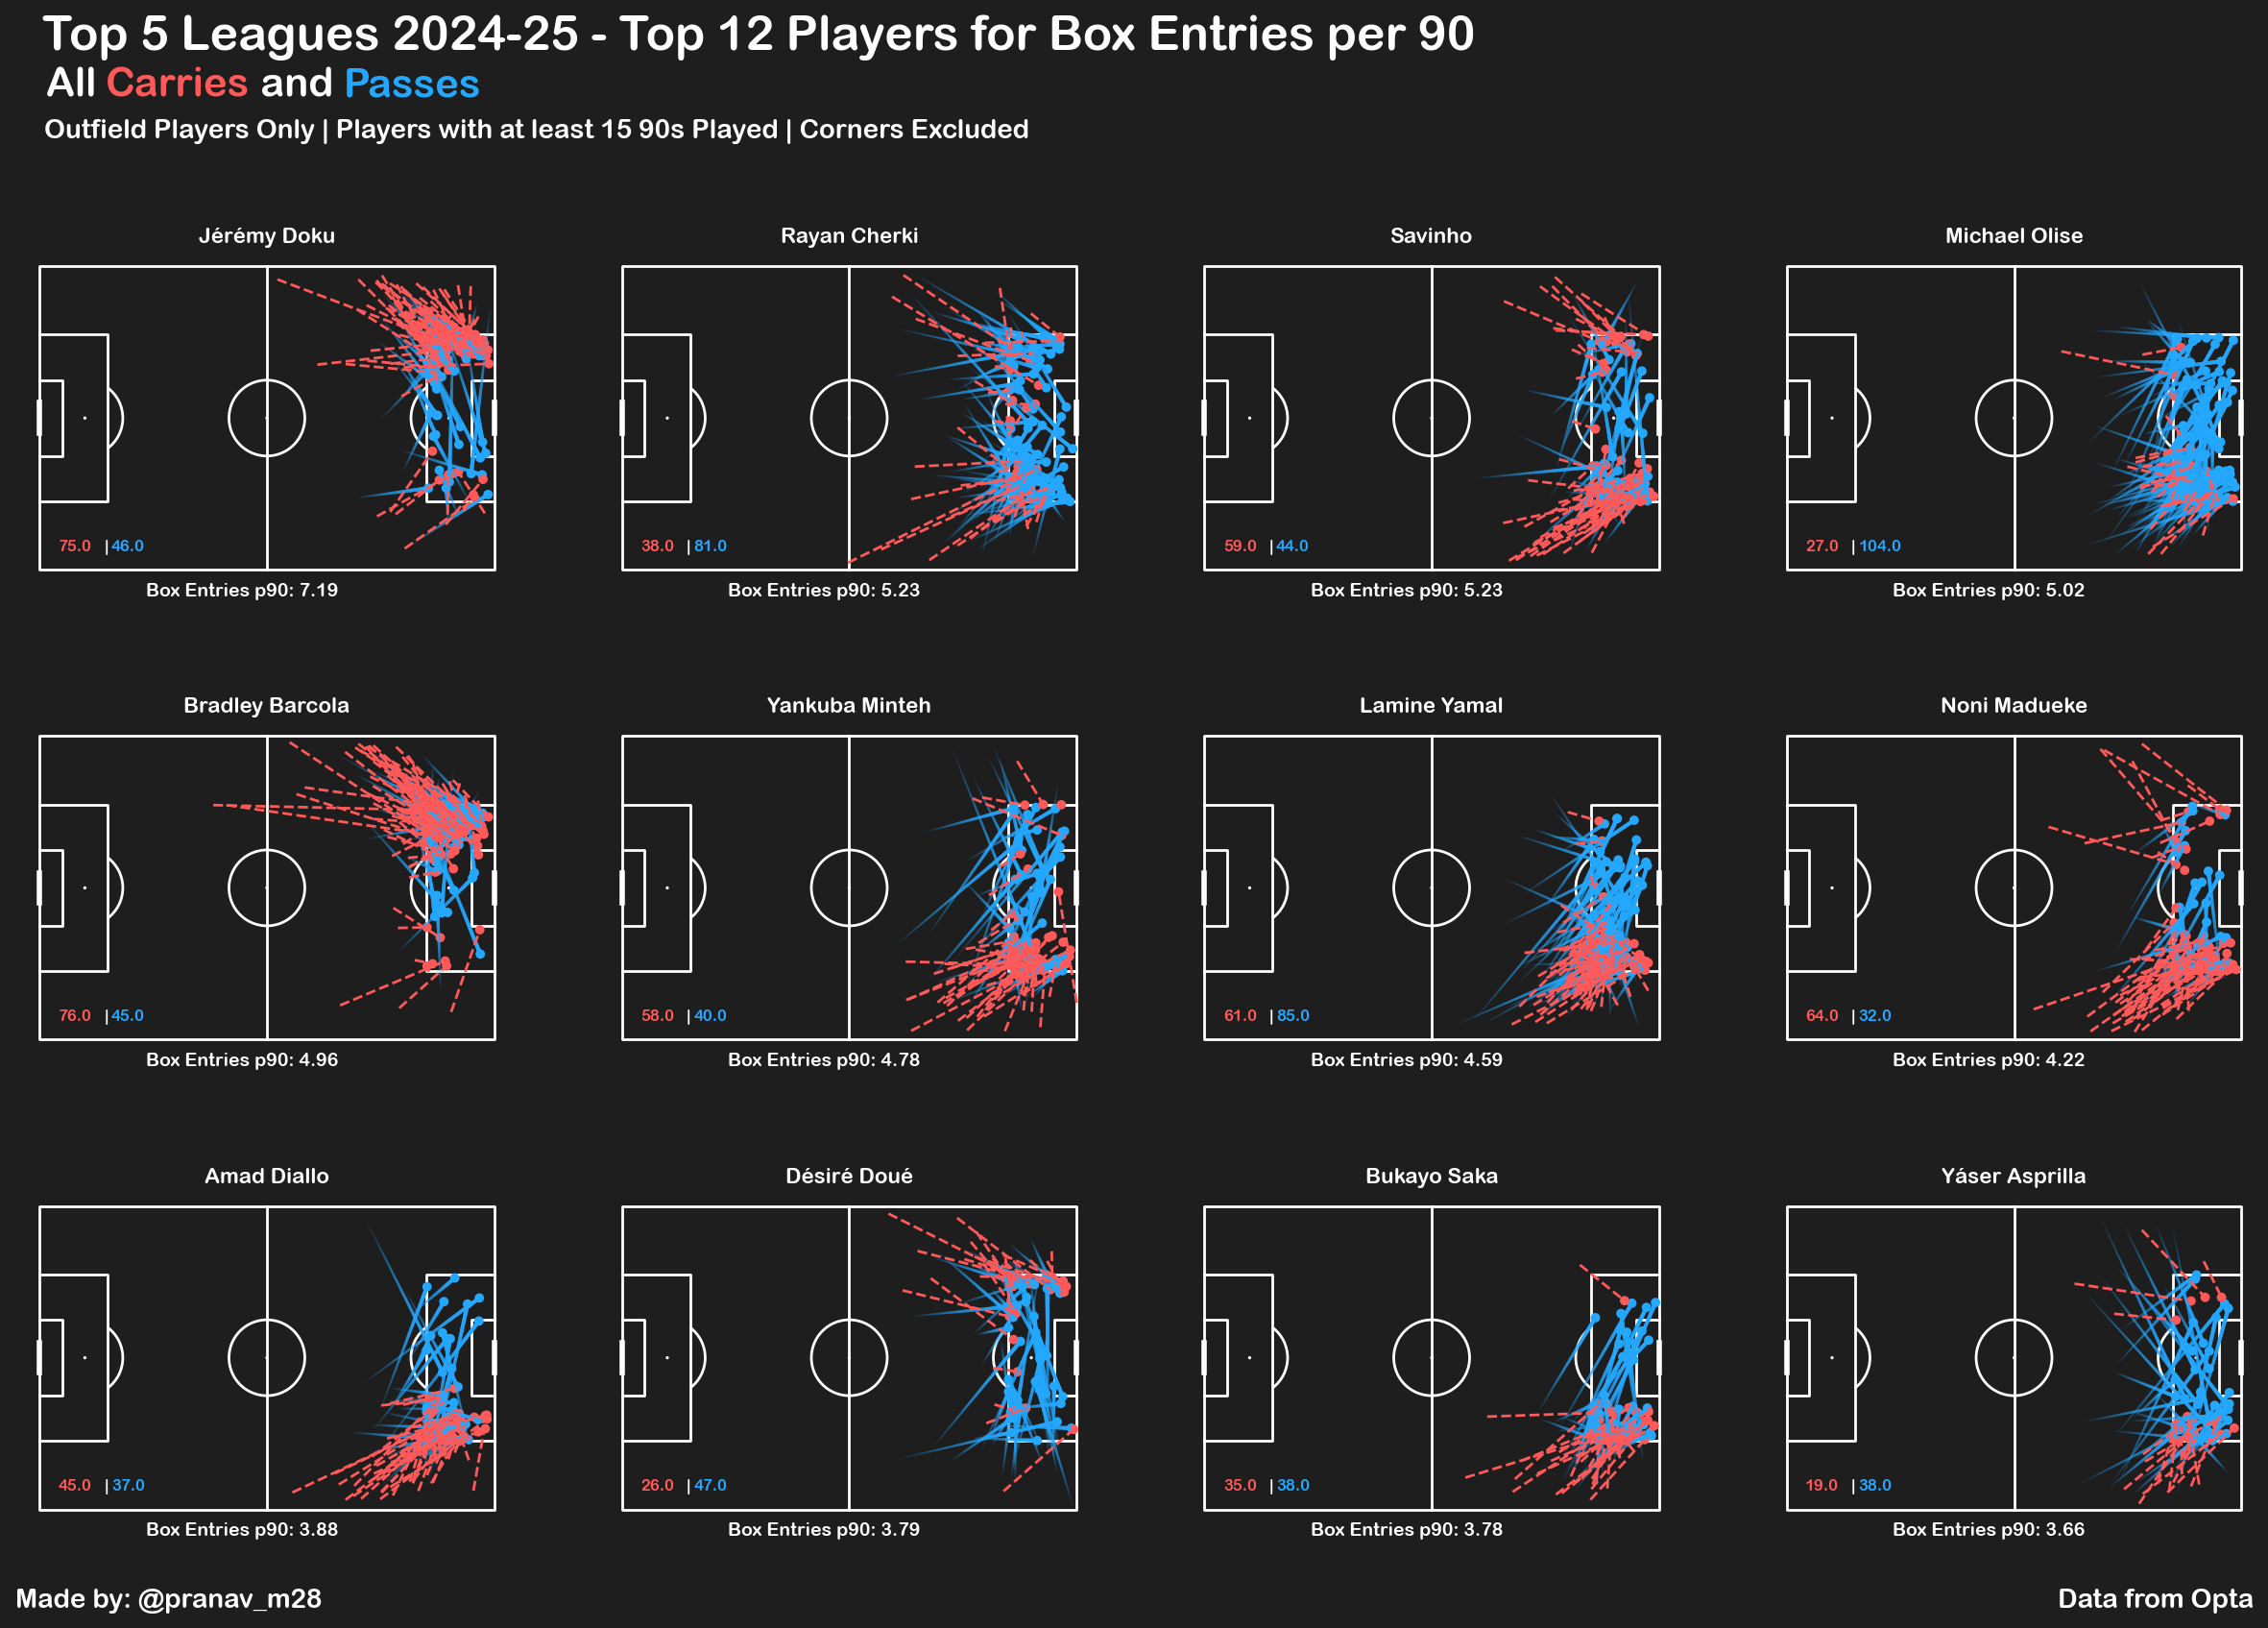

In [39]:
fig, axs = plt.subplots(3, 4, figsize=(30, 18))
fig.set_facecolor('#1e1e1e')

for ax, (_, player_data) in zip(axs.flatten(), top_12_box.iterrows()):
    player_id = player_data['playerId']
    player_name = player_data['player']
    box_passes_count = player_data['box_passes']
    box_carries_count = player_data['box_carries']
    box_act_p90 = player_data['box_actions_p90']
    
    player_passes = box_passes[box_passes['playerId'] == player_id]
    player_carries = box_carries[box_carries['playerId'] == player_id]
    
    pitch = Pitch(pitch_type='statsbomb', pitch_color='#1e1e1e', line_color='#FFFFFF')
    pitch.draw(ax=ax)
    
    
    pitch.lines(player_passes.x, player_passes.y, player_passes.endX, player_passes.endY,
                lw=3, transparent=True, comet=True, color='#24a8ff', ax=ax)
    pitch.scatter(player_passes.endX, player_passes.endY, s=50, marker='o', edgecolors='none', c='#24a8ff', ax=ax, alpha=1)
    
   
    pitch.lines(player_carries.x, player_carries.y, player_carries.endX, player_carries.endY, 
                ls='dashed', lw=2, transparent=False, comet=False, color='#FF5959', ax=ax)
    pitch.scatter(player_carries.endX, player_carries.endY, s=50, marker='o', edgecolors='none', c='#FF5959', ax=ax, alpha=1)
    
    ax.invert_yaxis()
    ax.set_title(f'{player_name}', font='Arial Rounded MT Bold', color='#FFFFFF', fontsize=16)
    
    ax.text(5, 5, f'{box_carries_count}', color='#FF5959', font='Arial Rounded MT Bold', fontsize=12, ha='left')
    ax.text(17, 5, '|', color='#FFFFFF', font='Arial Rounded MT Bold', fontsize=12, ha='left')
    ax.text(19, 5, f'{box_passes_count}', font='Arial Rounded MT Bold', color='#24A8FF', fontsize=12, ha='left')
    ax.text(28, -7, f'Box Entries p90: {box_act_p90:.2f}', font='Arial Rounded MT Bold', color='#FFFFFF', fontsize=14, ha='left')

fig_text(0.38, 1.00, "Top 5 Leagues 2024-25 - Top 12 Players for Box Entries per 90", ha="center", font='Arial Rounded MT Bold', color="#FFFFFF", fontsize=36, fontweight='bold')
fig_text(0.208, 0.97, "All <Carries> and <Passes>", ha="center", font='Arial Rounded MT Bold', color="#FFFFFF", fontsize=30, fontweight='bold', highlight_textprops=[{"color": '#FF5959'}, {"color": '#24A8FF'}])
fig_text(0.303, 0.94, "Outfield Players Only | Players with at least 15 90s Played | Corners Excluded", ha="center", font='Arial Rounded MT Bold', color="#FFFFFF", fontsize=20, fontweight='bold')


fig_text(0.175, 0.09, "Made by: @pranav_m28", ha="center", font='Arial Rounded MT Bold' ,color="#FFFFFF", fontsize=20, fontweight='bold')
fig_text(0.865, 0.09, "Data from Opta", ha="center", font='Arial Rounded MT Bold' ,color="#FFFFFF", fontsize=20, fontweight='bold')

#plt.savefig("T5_Box_Entries_2425.png" , dpi=300, bbox_inches='tight')
plt.show()